In [ ]:
# helper module imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# model imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor

# processing & metrics imports
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score 

In [34]:
ds_path = r'/run/media/sai/KALI_HDD/Agriculture-Market-Prediction/dataset.csv' 

df = pd.read_csv(ds_path)
print(df.shape[1])

9


In [35]:
df.rename(columns={
    "DISTRICT": "dst",
    "YEAR": "yr",
    "MONTH": "mnth",
    "SEASON": "ssn",
    "RAINFALL(in mm)": "rf",
    "TEMPERATURE(in Celsius)": "temp",
    "CROPS": "crp",
    "SUCCESSFUL CROPS": "scrp",
    "MARKET RATE(per kg)(in Rupees)": "mr"
}, inplace=True)

df.head(10)

,dst,yr,mnth,ssn,rf,temp,crp,scrp,mr
0,Ariyalur,2007,January,Rabi,101.0,23.7,Paddy,Paddy,80.0
1,Ariyalur,2007,February,Rabi,14.0,24.4,Maize,Paddy,70.0
2,Ariyalur,2007,March,Rabi,11.0,26.6,Cotton(lint),Maize,25.0
3,Ariyalur,2007,April,Kharif,11.0,28.4,Groundnut,Maize,30.0
4,Ariyalur,2007,May,Kharif,32.0,29.1,Sugarcane,Mango,100.0
5,Ariyalur,2007,June,Kharif,15.0,29.1,Cashewnut,Tomato,50.0
6,Ariyalur,2007,July,Kharif,11.0,29.2,Mango,Tomato,60.0
7,Ariyalur,2007,August,Kharif,20.0,29.1,Banana,Sugarcane,30.0
8,Ariyalur,2007,September,Kharif,35.0,28.6,Tapico,Sugarcane,40.0
9,Ariyalur,2007,October,Kharif,132.0,26.2,Tomato,Groundnut,130.0


In [61]:
df['dst_enc'] = pd.factorize(df['dst'])[0]
df['mnth_enc'] = pd.factorize(df['mnth'])[0]
df['ssn_enc'] = pd.factorize(df['ssn'])[0]

unique_values = pd.concat([df['crp'], df['scrp']]).unique()
mapping = {value: idx for idx, value in enumerate(unique_values)}
df['crp_enc'] = df['crp'].map(mapping)
df['scrp_enc'] = df['scrp'].map(mapping)
df = df.dropna()
df = df.sample(frac=1).reset_index(drop=True)

df.head(10)

,level_0,index,dst,yr,mnth,ssn,rf,temp,crp,scrp,mr,dst_enc,crp_enc,scrp_enc,mnth_enc,ssn_enc
0,1863,2327,Karur,2013,December,Rabi,7.1,26.90,Groundnut,Banana,55.0,11,10,5,5,0
1,7232,6906,Tiruvannamalai,2021,July,Kharif,212.6,34.10,Bajra,Ragi,75.0,21,15,48,11,1
2,1510,3912,Pudukkottai,2010,January,Rabi,22.5,27.00,Coconut,Coconut,35.0,15,24,122,0,0
3,3924,2958,Mayiladuthurai,2015,July,Kharif,55.7,29.40,Black gram,Cotton,70.0,13,14,29,11,1
4,1608,2992,Mayiladuthurai,2018,May,Kharif,4.8,32.60,Sugarcane,Mango,130.0,13,6,12,10,1
5,6956,5218,Thanjavur,2016,November,Rabi,122.6,29.29,Cocoa,Groundnut,125.0,17,101,10,4,0
6,3892,2402,Karur,2020,March,Rabi,1.4,32.40,Green gram,Sugarcane,35.0,11,61,6,9,0
7,7037,385,Chengalpattu,2022,February,Rabi,0.0,24.70,Groundnut,Greens,60.0,1,10,86,7,0
8,3888,2183,Kanniyakumari,2018,December,Rabi,2.8,27.90,Cocoa,Cocoa,600.0,23,101,101,5,0
9,6933,2711,Madurai,2011,December,Rabi,118.8,27.80,Turmeric,Sesame,140.0,7,7,40,5,0


In [62]:

X = df[['dst_enc', 'yr', 'mnth_enc', 'ssn_enc', 'rf', 'temp', 'crp_enc', 'scrp_enc']]
Y = df['mr']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [70]:
models = [
    ('RandomForest',         RandomForestRegressor(criterion='squared_error')),
    ('ExtraTreesRegression', ExtraTreesRegressor(criterion='squared_error')),
    ('GBRegression',         GradientBoostingRegressor(criterion='squared_error')),
    ('XGBRegressor',         XGBRegressor())
]


model_comps = []

for model_name, model in models:
    model.fit(X_train, Y_train)
    joblib.dump(model, f'Model_WT/{model_name}_model.pkl')
    accuracies = cross_val_score(model, X_train, Y_train, scoring='neg_mean_squared_error', cv=5)
    for count, accuracy in enumerate(accuracies):
        model_comps.append((model_name, count, accuracy))

result_df = pd.DataFrame(model_comps, columns=['model_name', 'count', 'accuracy'])
result_df.pivot(index='count', columns='model_name', values='accuracy').boxplot(rot=45)

<Axes: >

Model:               Random Forest
MSE:                 1418.8973
RMSE:                37.6683
MAE:                 12.3063
R²:                  0.9201
Explained Variance:  0.9201
--------------------------------------------------


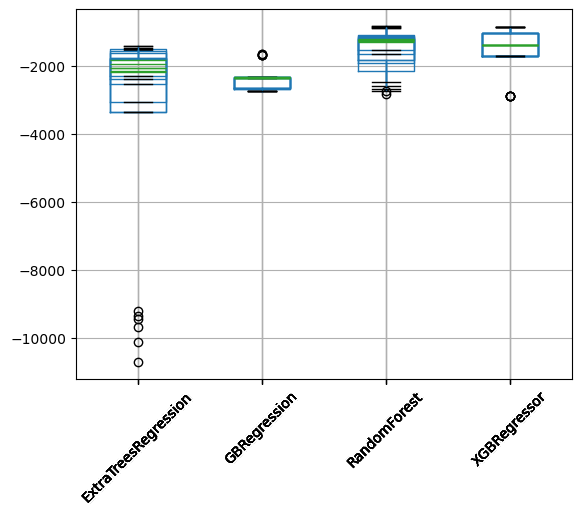

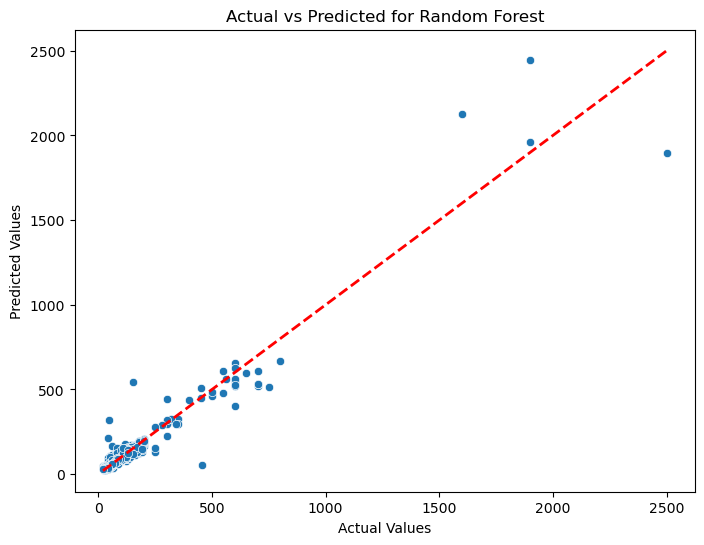

Model:               ET Regression
MSE:                 2506.0871
RMSE:                50.0608
MAE:                 16.4664
R²:                  0.8589
Explained Variance:  0.8589
--------------------------------------------------


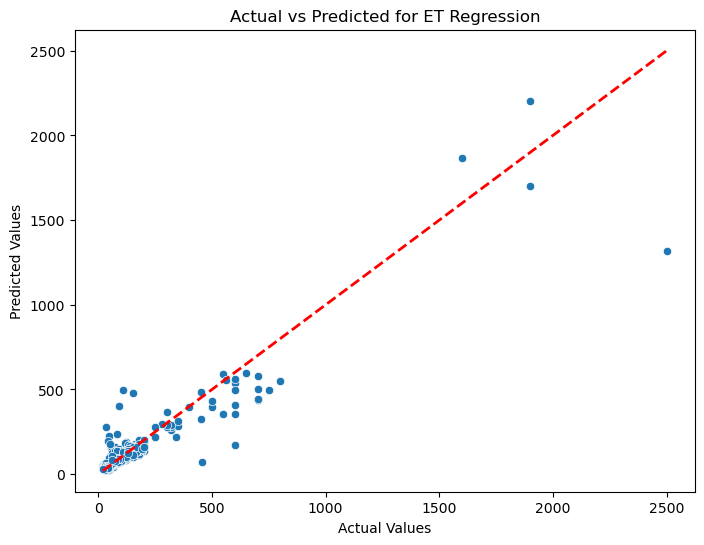

Model:               GB Regression
MSE:                 2247.7444
RMSE:                47.4104
MAE:                 21.4242
R²:                  0.8734
Explained Variance:  0.8735
--------------------------------------------------


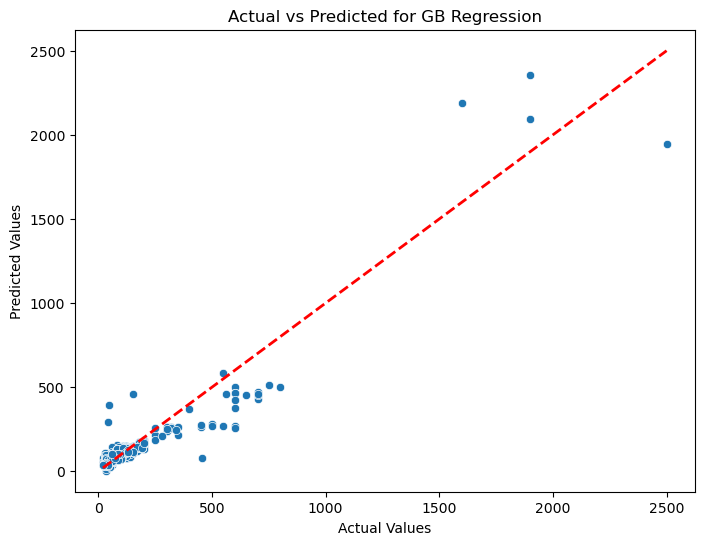

Model:               XGBoost Regression
MSE:                 1464.5203
RMSE:                38.2691
MAE:                 12.9632
R²:                  0.9175
Explained Variance:  0.9176
--------------------------------------------------


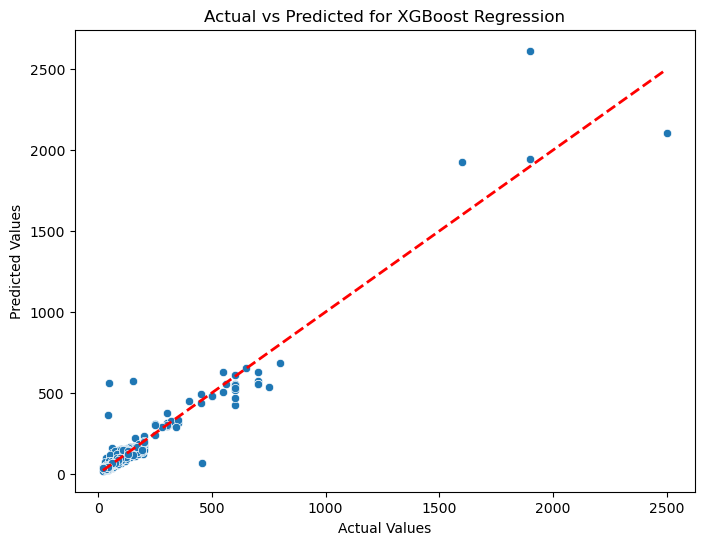

                            MSE       RMSE        MAE        R²  \
Random Forest       1418.897266  37.668253  12.306344  0.920101   
ET Regression       2506.087111  50.060834  16.466390  0.858880   
GB Regression       2247.744410  47.410383  21.424227  0.873427   
XGBoost Regression  1464.520260  38.269051  12.963244  0.917532   

                    Explained Variance  
Random Forest                 0.920102  
ET Regression                 0.858880  
GB Regression                 0.873472  
XGBoost Regression            0.917554  


In [74]:
rf_model = joblib.load(r'Model_WT/RandomForest_model.pkl')
et_model = joblib.load(r'Model_WT/ExtraTreesRegression_model.pkl')
gb_model = joblib.load(r'Model_WT/GBRegression_model.pkl')
xgb_model = joblib.load(r'Model_WT/XGBRegressor_model.pkl')

def evaluate_regression_model(model, X_train, Y_train, X_test, Y_test, model_name, results_dict):
    predictions = model.predict(X_test)
    mse = mean_squared_error(Y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(Y_test, predictions)
    r2 = r2_score(Y_test, predictions)
    explained_variance = explained_variance_score(Y_test, predictions)

    results_dict[model_name] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'Explained Variance': explained_variance
    }

    print(f"{'Model:'.ljust(20)} {model_name}")
    print(f"{'MSE:'.ljust(20)} {mse:.4f}")
    print(f"{'RMSE:'.ljust(20)} {rmse:.4f}")
    print(f"{'MAE:'.ljust(20)} {mae:.4f}")
    print(f"{'R²:'.ljust(20)} {r2:.4f}")
    print(f"{'Explained Variance:'.ljust(20)} {explained_variance:.4f}")
    print("-" * 50)


    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=Y_test, y=predictions)
    plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', lw=2)
    plt.title(f'Actual vs Predicted for {model_name}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()

results = {}

evaluate_regression_model(rf_model, X_train, Y_train, X_test, Y_test, 'Random Forest', results)
evaluate_regression_model(et_model, X_train, Y_train, X_test, Y_test, 'ET Regression', results)
evaluate_regression_model(gb_model, X_train, Y_train, X_test, Y_test, 'GB Regression', results)
evaluate_regression_model(xgb_model, X_train, Y_train, X_test, Y_test, 'XGBoost Regression', results)

results_df = pd.DataFrame(results).T
print(results_df)